# <center>MVTS Data Toolkit</center>
## <center>A Toolkit for Pre-processing Multivariate Time Series Data</center>

<img src="./__icon/MVTS_Data_Toolkit_icon2.png">

* **Title:** MVTS Data Toolkit: A Toolkit for Pre-processing Multivariate Time Series Data
* **Journal:** SoftwareX Journal (Elsevier)
* **Authors:** Azim Ahmadzadeh [$\oplus$](https://www.azim-a.com/), Kankana Sinha [$\ominus$](https://www.linkedin.com/in/kankana-sinha-4b4b13131/), Berkay Aydin [$\otimes$](https://grid.cs.gsu.edu/~baydin2/), Rafal A. Angryk [$\oslash$](https://grid.cs.gsu.edu/~rangryk/)
* **Demo Author:** Azim Ahmadzadeh
* **Last Modified:** Jan 24, 2020

## Intro

This demo gives a quick tour over the toolkit's funcionalities. Here I will:
 1. download a multi-class dataset of 2000 multivariate time series (mvts) instances,
 2. show how the configuration file can be prepared,
 3. get some basic statistics about the data,
 4. extract multiple statistical features from the mvts instances, and visualize the results,
 5. analyze the extracted-feature data,
 6. normalize the extracted features,
 7. sample the extracted data to obtain a different ratios of the five classes.

In [1]:
import os
import yaml
from data.data_retriever import DataRetriever  # for downloading data
import CONSTANTS as CONST

## 1. Download the Dataset
In this demo I use an example dataset. In the following cells, it will be automatically downloaded. But in case something goes wrong, here is the direct link:
https://bitbucket.org/gsudmlab/mvtsdata_toolkit/downloads/petdataset_01.zip
. Please note that here I am using the class `DataRetriever` that I implemented. This is only implemented for the purpose of this demo and is not one of the generic tools to be used for any other datasets.

Before we download it, let's take a quick look:

In [2]:
dr = DataRetriever(1)
dr.print_info()

URL:		https://bitbucket.org/gsudmlab/mvtsdata_toolkit/downloads/petdataset_01.zip
NAME:		petdataset_01.zip
TYPE:		application/zip
SIZE:		32M


Ready to download? This may take a few seconds, depending on your internet bandwidth. Wait for the progress bar.

In [3]:
where_to = './temp/'  # Don't change this path.
dr.retrieve(target_path = where_to)

Extracting: 100%|██████████| 2001/2001 [00:00<00:00, 2913.87it/s]


OK. Let's see how many files are available to us now.

In [4]:
dr.get_total_number_of_files()

2000

## 2. Setup Configurations
For tasks such as feature extraction (module: `features.feature_extractor`) and data analysis (modules: `data_analysis.mvts_data_analysis` and `data_analysis.extracted_features_analysis`) a configuration file must be provided by the user. There is one already provided inside this package, but you can create your own and place it anywhere you wish.

Let's take a look at the provided config file which is located at `./configs/demo_configs.yml`:

In [5]:
path_to_config = './configs/demo_configs.yml'
with open(path_to_config, 'r') as f:
    print(f.read())

PATH_TO_MVTS: './temp/petdataset_01/'
PATH_TO_EXTRACTED_FEATURES: './temp/extracted_features/'
META_DATA_TAGS: ['id', 'lab', 'st', 'et']
MVTS_PARAMETERS:
  - 'TOTUSJH'
  - 'TOTBSQ'
  - 'TOTPOT'
  - 'TOTUSJZ'
  - 'ABSNJZH'
  - 'SAVNCPP'
  - 'USFLUX'
  - 'TOTFZ'
  - 'MEANPOT'
  - 'EPSZ'
  - 'MEANSHR'
  - 'SHRGT45'
  - 'MEANGAM'
  - 'MEANGBT'
  - 'MEANGBZ'
  - 'MEANGBH'
  - 'MEANJZH'
  - 'TOTFY'
  - 'MEANJZD'
  - 'MEANALP'
  - 'TOTFX'
  - 'EPSY'
  - 'EPSX'
  - 'R_VALUE'
STATISTICAL_FEATURES:
  - 'get_min'
  - 'get_max'
  - 'get_median'
  - 'get_mean'
  - 'get_stddev'
  - 'get_var'
  - 'get_skewness'
  - 'get_kurtosis'
  - 'get_no_local_maxima'
  - 'get_no_local_minima'
  - 'get_no_local_extrema'
  - 'get_no_zero_crossings'
  - 'get_mean_local_maxima_value'
  - 'get_mean_local_minima_value'
  - 'get_no_mean_local_maxima_upsurges'
  - 'get_no_mean_local_minima_downslides'
  - 'get_difference_of_mins'
  - 'get_difference_of_maxs'
  - 'get_difference_of_means'
  - 'get_difference_of_stds'
  -

Here is the break-down of the pieces:
 - `PATH_to_MVTS`: A relative or absolute path to where the multivariate time series dataset is stored at.
 - `PATH_TO_EXTRACTED`: A relative or absolute path to where the extracted features should be stored at, using the Feature Extraction component of the package.
 - `META_DATA_TAGS`: A list of tags based on which some pieces of information can be extracted from the file-names of the multivariate time series. For example, if timestamps are encoded in the file-names, e.g., `_st[YYYY-MM-DD HH:MM:SS]`, then the string `st` (without brackets) is a tag that can be included in this list. In the feature extraction process, this will add the corresponding metadata (i.e., what is wrapped in the square brackets) in each filename, as an extra column to the data-frame of the extracted features. Generally, using this functionality, any extra metadata (e.g., class labels, start-time, end-time, id's, etc) can be encoded in the file-names and consequently passed into the extracted features.
 - `MVTS_PARAMETERS`: A list of parameter-names that are used in the multivariate time series dataset, whose statistical features are of interest. These are, in other words, the column-names in the multivariate time series files.
 - `STATISTICAL_FEATURES`: A list of statistical features of interest to be extracted from the multivariate time series. They must be chosen from the provided methods in the module `features.feature_collection.`. For example, `get_min` is a valid feature-name as this method is implemented in the package.
 
 In the following steps, you will see how this can be used.

## 3. Analysis of Raw Data (MVTS Data Analysis)

- #### How many files? How large of a dataset?

Using `mvts_data_analysis` module users can get an idea of the dataset they are going to work on. I start with creating an instance of the `MVTSDataAnalysis` class. This right away gives me some high-level information about the dataset.

In [6]:
from data_analysis.mvts_data_analysis import MVTSDataAnalysis
path_to_config = './configs/demo_configs.yml'
mvda = MVTSDataAnalysis(path_to_config)
mvda.print_stat_of_directory()

----------------------------------------
Directory:			/home/azim/CODES/PyCode/mvtsdata_toolkit/./temp/petdataset_01/
Total no. of files:	2000
Total size:			76M
Total average:		38K
----------------------------------------


- #### Get a summary stats of the data.

Let's now get some statistics from the content of the files. To speed up the demo, I analyze only 3 time series parameters (namely `TOTUSJH`, `TOTBSQ`, and `TOTPOT`), and only the first 50 mvts files.

In [7]:
params = ['TOTUSJH', 'TOTBSQ', 'TOTPOT']
n = 50
mvda.compute_summary(params_name=params, first_k=n)
mvda.summary

,Parameter-Name,Val-Count,Null-Count,mean,min,25th,50th,75th,max
0,TOTUSJH,3000,0,8.042049e+02,4.341081e+00,5.958928e+01,3.491322e+02,1.122475e+03,3.746423e+03
1,TOTBSQ,3000,0,1.149033e+10,2.376532e+07,4.002768e+08,4.548424e+09,1.445496e+10,6.957558e+10
2,TOTPOT,3000,0,1.871504e+23,1.750878e+20,2.813272e+21,3.833374e+22,2.628054e+23,1.425084e+24


... which says the length of the time series, across the 50 mvts files is 3000, including 0 `NA/NAN` values. In addition, `mean`, `min`, `max`, and three quantiles are calculated for each time series.

 - #### You have a LARGE dataset?
 A parallel version of this function is also provided to help process much larger datasets efficiently. Below, we will have 4 processes to compute the summary statistics.

In [8]:
mvda.compute_summary_in_parallel(n_jobs=4, first_k=50, verbose=False,
                                     params_name=['TOTUSJH', 'TOTBSQ', 'TOTPOT'])
mvda.summary

,Parameter-Name,Val-Count,Null-Count,mean,min,25th,50th,75th,max
0,TOTUSJH,3000,0,7.996792e+02,4.341081e+00,5.956526e+01,3.518033e+02,1.118315e+03,3.746423e+03
1,TOTBSQ,3000,0,1.140743e+10,2.376532e+07,4.005768e+08,4.472540e+09,1.446497e+10,6.957558e+10
2,TOTPOT,3000,0,1.855639e+23,1.750878e+20,2.815218e+21,3.835158e+22,2.628142e+23,1.425084e+24


**Note**: The results of the parallel and sequential versions of `mvts_data_analysis` are not exactly identical. This discrepency is due to the fact that in the parallel version, the program has to approximate the percentiles. More specifically, it is designed to avoid loading the entire dataset into memory so that it is not confined to any particular data size. Therefore, it relies on some statistical estimators to approximate the percentiles with some acceptable error. The errors decrease significantly as the number of mvts files increases. In conclusion, for small datasets I recommend using the sequential version.

## 4. Feature Extraction

- #### What statistical features are available?

Now that we have an idea about our raw data, let's extract some features from the data. A list of 48 statistical features are implemented in `feature_collection`. Let's take a look at them.

In [9]:
import features.feature_collection as fc
help(fc)

Help on module features.feature_collection in features:

NAME
    features.feature_collection

FUNCTIONS
    get_average_absolute_change(uni_ts:Union[pandas.core.series.Series, numpy.ndarray]) -> numpy.float64
        :return: the average absolute first difference of a univariate time series.
    
    get_average_absolute_derivative_change(uni_ts:Union[pandas.core.series.Series, numpy.ndarray]) -> numpy.float64
        :return: the average absolute first difference of a derivative of univariate time series.
    
    get_avg_mono_decrease_slope(uni_ts:Union[pandas.core.series.Series, numpy.ndarray]) -> numpy.float64
        :return: the average slope of monotonically decreasing segments.
    
    get_avg_mono_increase_slope(uni_ts:Union[pandas.core.series.Series, numpy.ndarray]) -> numpy.float64
        :return: the average slope of monotonically increasing segments.
    
    get_dderivative_kurtosis(uni_ts:Union[pandas.core.series.Series, numpy.ndarray], step_size:int=1) -> numpy.float

- #### How to extract these features from the data?

Let's extract 3 simple statistical features, namely `min`, `max`, and `median`, from 3 parameters, such as `TOTUSJH`, `TOTBSQ`, and `TOTPOT`. Again, to speed up the process in this demo, we only process the first 50 mvts files.

In [10]:
from features.feature_extractor import FeatureExtractor

fe = FeatureExtractor(path_to_config)
fe.do_extraction(features_name=['get_min', 'get_max', 'get_median'],
                 params_name=['TOTUSJH', 'TOTBSQ', 'TOTPOT'], first_k=50)
fe.df_all_features

,id,lab,st,et,TOTUSJH_min,TOTUSJH_max,TOTUSJH_median,TOTBSQ_min,TOTBSQ_max,TOTBSQ_median,TOTPOT_min,TOTPOT_max,TOTPOT_median
0,3894,M,2014-03-29T22:00:00,2014-03-30T09:48:00,967.434905,1183.833149,1124.410250,1.046786e+10,1.188663e+10,1.153321e+10,1.228731e+23,1.716971e+23,1.492330e+23
1,3364,NF,2013-11-10T16:24:00,2013-11-11T04:12:00,785.515878,898.419700,841.636672,1.384462e+10,1.505713e+10,1.449548e+10,2.558560e+23,2.903506e+23,2.712413e+23
2,3401,NF,2013-11-19T15:00:00,2013-11-20T02:48:00,43.795702,79.405460,61.347579,3.006945e+08,4.249081e+08,3.883491e+08,1.854126e+21,3.078696e+21,2.787184e+21
3,3595,NF,2014-01-12T09:24:00,2014-01-12T21:12:00,48.647340,65.213699,54.220981,3.276020e+08,4.447089e+08,3.539810e+08,2.278193e+21,3.308322e+21,2.707839e+21
4,3452,NF,2013-12-06T18:24:00,2013-12-07T06:12:00,54.910546,89.248031,64.519227,3.395135e+08,6.300441e+08,4.605988e+08,2.030967e+21,4.775595e+21,2.968826e+21
5,3401,NF,2013-11-23T00:00:00,2013-11-23T11:48:00,16.406938,25.926148,20.134504,1.098692e+08,1.766917e+08,1.430579e+08,6.961236e+20,1.368650e+21,9.542322e+20
6,3313,NF,2013-10-29T06:48:00,2013-10-29T18:36:00,25.213735,45.237145,37.858018,1.640152e+08,3.040086e+08,2.364114e+08,1.079530e+21,2.178500e+21,1.615138e+21
7,3394,NF,2013-11-16T12:48:00,2013-11-17T00:36:00,37.198119,105.665566,74.004088,4.422474e+08,1.066918e+09,7.937949e+08,2.419303e+21,6.886243e+21,4.586577e+21
8,3779,C,2014-02-26T06:24:00,2014-02-26T18:12:00,761.638915,987.804217,901.833056,5.706467e+09,7.378234e+09,6.651778e+09,5.153352e+22,7.974288e+22,7.048366e+22
9,3364,C,2013-11-17T20:24:00,2013-11-18T08:12:00,3410.057526,3746.423110,3583.958457,4.832398e+10,5.258952e+10,5.117475e+10,7.566750e+23,8.037784e+23,7.870867e+23


... where each row corresponds to one mvts file, and the first 4 columns represent the extracted information from the file-names using the tags specified in the configuration file (i.e., `id`, `lab`, `st`, and `et`). The remaining columns contains the extracted features. They are named by appending each statistical-feature name to the end of a parameter-name, e.g., `TOTUSJH_min`.

 - #### You have a LARGE dataset?
 No worries. Using the parallel implementation of the feature extraction process, this can be significantly sped up. Let's have 4 processes to extract the features.

In [11]:
fe.do_extraction_in_parallel(n_jobs=4,
                             features_name=['get_min', 'get_max', 'get_median'],
                             params_name=['TOTUSJH', 'TOTBSQ', 'TOTPOT'], first_k=50)
fe.df_all_features

,id,lab,st,et,TOTUSJH_min,TOTUSJH_max,TOTUSJH_median,TOTBSQ_min,TOTBSQ_max,TOTBSQ_median,TOTPOT_min,TOTPOT_max,TOTPOT_median
0,3597,NF,2014-01-08T05:36:00,2014-01-08T17:24:00,4.341081,12.261190,7.426589,2.376532e+07,6.548704e+07,3.557751e+07,1.750878e+20,6.645951e+20,3.158317e+20
1,3497,C,2013-12-18T03:24:00,2013-12-18T15:12:00,1681.484071,1910.445613,1770.638465,2.073974e+10,2.410021e+10,2.338266e+10,3.894755e+23,4.511897e+23,4.312311e+23
2,3394,NF,2013-11-21T15:48:00,2013-11-22T03:36:00,32.492713,46.587421,39.022541,2.182987e+08,3.187070e+08,2.731201e+08,1.683164e+21,3.047398e+21,2.492267e+21
3,3813,C,2014-03-08T12:24:00,2014-03-09T00:12:00,804.514582,996.695003,887.737665,6.958456e+09,8.610843e+09,7.866284e+09,7.628546e+22,9.166733e+22,8.168197e+22
4,3480,NF,2013-12-10T07:36:00,2013-12-10T19:24:00,49.251799,83.605791,60.072664,4.090207e+08,6.371692e+08,5.076699e+08,2.802586e+21,5.647560e+21,4.049899e+21
5,3288,C,2013-10-19T20:48:00,2013-10-20T08:36:00,540.275179,669.071529,579.449611,3.820681e+09,4.442559e+09,4.183424e+09,3.335796e+22,4.098702e+22,3.797803e+22
6,3400,NF,2013-11-26T11:12:00,2013-11-26T23:00:00,331.070081,416.835571,389.407235,7.495902e+09,8.156456e+09,8.016263e+09,1.334339e+23,1.474803e+23,1.422880e+23
7,3273,NF,2013-10-21T15:00:00,2013-10-22T02:48:00,297.765488,352.122224,322.602994,2.369360e+09,2.773179e+09,2.640721e+09,1.672819e+22,2.035788e+22,1.935193e+22
8,3364,C,2013-11-08T21:24:00,2013-11-09T09:12:00,619.818638,707.927819,667.581645,1.208091e+10,1.312152e+10,1.269257e+10,1.912164e+23,2.105895e+23,2.030179e+23
9,3287,NF,2013-10-15T23:36:00,2013-10-16T11:24:00,60.458600,98.430700,71.548267,6.041495e+08,7.586510e+08,6.371173e+08,4.280842e+21,7.113572e+21,4.754370e+21


**Note**: Although both of the tables (using single or multiple processes) are identical, due to the use of multiprocessing, in the second dataframe, the order of the rows are not presernved. Using a unique value, e.g., `id` of each mvts, they can be easily matched and compared.

 - #### Need to visulaize it?
 There are multiple visualizations incorporated in this package that are called in the `FeatureExtractor` class. Here is how you can used them:

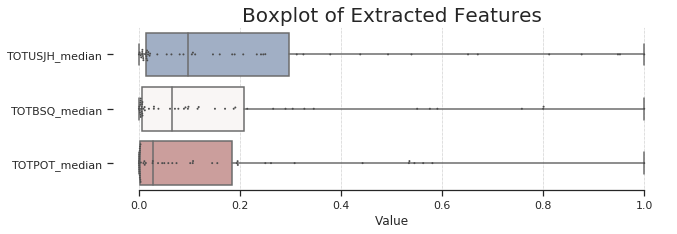

In [15]:
fe.plot_boxplot(feature_names=['TOTUSJH_median', 'TOTBSQ_median', 'TOTPOT_median'])

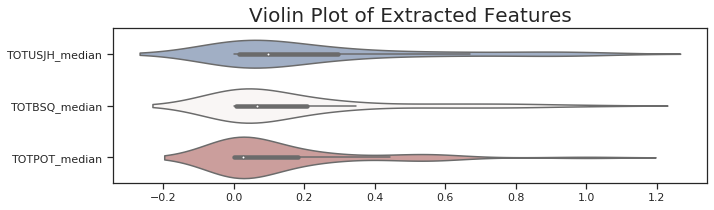

In [13]:
fe.plot_violinplot(feature_names=['TOTUSJH_median', 'TOTBSQ_median', 'TOTPOT_median'])

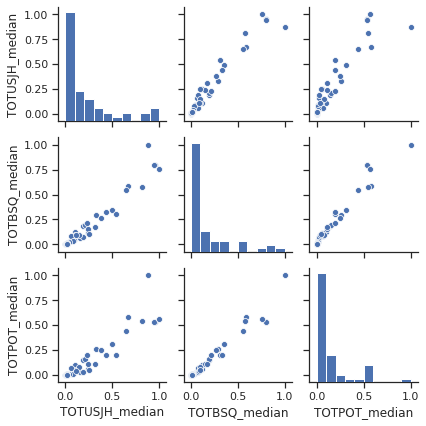

In [14]:
fe.plot_splom(feature_names=['TOTUSJH_median', 'TOTBSQ_median', 'TOTPOT_median'])

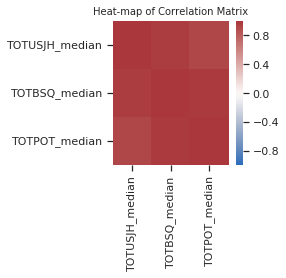

In [16]:
fe.plot_correlation_heatmap(feature_names=['TOTUSJH_median', 'TOTBSQ_median', 'TOTPOT_median'])

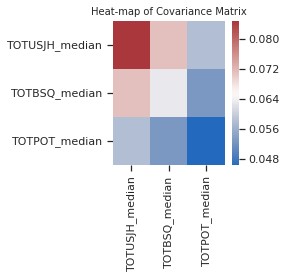

In [17]:
fe.plot_covariance_heatmap(feature_names=['TOTUSJH_median', 'TOTBSQ_median', 'TOTPOT_median'])

For all of these plots, it is a common practice to have the data normalized before generating such plots. This is automatically done in the above steps. Iin rare cases that normaliztion should not take place, using the `StatVisualizer` class in `stat_visualizer` module, this can be avoided.

Moreover, in any of the above visulization methods, by setting a path to the argument `output_path`, the generated plots can be stored as *png* files, instead of being shown through the GUI.

## 5. Extracted Features Analysis

- #### A quick look over the results?

The extracted features can be easily summarized using descriptive statistics such as `meam`, `std`, `min`, `max`, and first, second and third quartiles. In addition, any missing value can also be spotted.

In [18]:
from data_analysis.extracted_features_analysis import ExtractedFeaturesAnalysis

efa = ExtractedFeaturesAnalysis(fe.df_all_features, exclude=['id'])
efa.compute_summary()
efa.summary

,Feature-Name,Val-Count,Null-Count,mean,std,min,25th,50th,75th,max
0,TOTUSJH_min,50.0,0,7.341838e+02,9.667145e+02,4.341081e+00,4.879846e+01,3.144178e+02,9.276320e+02,3.410058e+03
1,TOTUSJH_max,50.0,0,8.746654e+02,1.112331e+03,1.226119e+01,7.940546e+01,3.981758e+02,1.137049e+03,3.746423e+03
2,TOTUSJH_median,50.0,0,8.033427e+02,1.041983e+03,7.426589e+00,6.063404e+01,3.522123e+02,1.068766e+03,3.583958e+03
3,TOTBSQ_min,50.0,0,1.076656e+10,1.574154e+10,2.376532e+07,3.388376e+08,4.200314e+09,1.340520e+10,5.766012e+10
4,TOTBSQ_max,50.0,0,1.210067e+10,1.744910e+10,6.548704e+07,4.603817e+08,4.922122e+09,1.470204e+10,6.957558e+10
5,TOTBSQ_median,50.0,0,1.158519e+10,1.697273e+10,3.557751e+07,4.064115e+08,4.513584e+09,1.409818e+10,6.751291e+10
6,TOTPOT_min,50.0,0,1.778611e+23,2.921604e+23,1.750878e+20,2.100021e+21,3.426977e+22,2.431402e+23,1.369838e+24
7,TOTPOT_max,50.0,0,1.971327e+23,3.104716e+23,6.645951e+20,3.355905e+21,4.175589e+22,2.739604e+23,1.425084e+24
8,TOTPOT_median,50.0,0,1.872583e+23,3.006618e+23,3.158317e+20,2.797750e+21,3.834246e+22,2.577412e+23,1.398754e+24


... which gives a summary statistics over every extracted feature. For instance, in row `0` that corresponds to the extracted feature `TOTUSJH_min`, the changes of the minimum values of the parameter `TUOTUSJH`, across 50 mvts files, is described in terms of `mean`, `std`, `min`, `25th` (percentile), `50th` (i.e., median), `75th` (percentile), and `max`. It also indicates that no `NA/NAN` or missing value was generated in the process.

## 6. Data Normalization

The extracted features can also be normalized using four different methods. Below, I use the zero-one normalization to transform values of each time-series (independently) to the `[0,1]` interval.

In [19]:
from normalizing import normalizer

df_norm = normalizer.zero_one_normalize(df=fe.df_all_features, excluded_colnames=['id'])
df_norm

,id,lab,st,et,TOTUSJH_min,TOTUSJH_max,TOTUSJH_median,TOTBSQ_min,TOTBSQ_max,TOTBSQ_median,TOTPOT_min,TOTPOT_max,TOTPOT_median
0,3597,NF,2014-01-08T05:36:00,2014-01-08T17:24:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3497,C,2013-12-18T03:24:00,2013-12-18T15:12:00,0.492449,0.508329,0.492995,0.359425,0.345773,0.345999,0.284231,0.316287,0.308140
2,3394,NF,2013-11-21T15:48:00,2013-11-22T03:36:00,0.008266,0.009192,0.008834,0.003375,0.003643,0.003520,0.001101,0.001673,0.001556
3,3813,C,2014-03-08T12:24:00,2014-03-09T00:12:00,0.234950,0.263629,0.246135,0.120318,0.122937,0.116049,0.055569,0.063888,0.058184
4,3480,NF,2013-12-10T07:36:00,2013-12-10T19:24:00,0.013187,0.019106,0.014720,0.006684,0.008224,0.006996,0.001918,0.003498,0.002670
5,3288,C,2013-10-19T20:48:00,2013-10-20T08:36:00,0.157363,0.175892,0.159938,0.065877,0.062970,0.061470,0.024227,0.028308,0.026932
6,3400,NF,2013-11-26T11:12:00,2013-11-26T23:00:00,0.095935,0.108344,0.106802,0.129643,0.116400,0.118272,0.097293,0.103071,0.101522
7,3273,NF,2013-10-21T15:00:00,2013-10-22T02:48:00,0.086156,0.091014,0.088123,0.040696,0.038954,0.038608,0.012086,0.013825,0.013612
8,3364,C,2013-11-08T21:24:00,2013-11-09T09:12:00,0.180719,0.186298,0.184580,0.209193,0.187829,0.187574,0.139481,0.147376,0.144949
9,3287,NF,2013-10-15T23:36:00,2013-10-16T11:24:00,0.016477,0.023076,0.017928,0.010070,0.009972,0.008915,0.002998,0.004527,0.003174


**Note**: The argument `excluded_colnames` is used to keep the column `id` unchanged in the normalization process. Although this column is numeric, normalization of its values would be meaningless. Moreover, any other column with non-numeric values were automatically preserved in the output.

## 7. Data Sampling

Very often our dataset suffers from the class-imbalance issue, especially when we are dealing with forecast/classification of natural phenomena. There are several generic methods in `sampling.sampler` modules that allows numerous different undersampling and oversampling techniques. Below, I will show some of them.

First, I create a `Sampler` and check out the population of each class.

In [22]:
from sampling.sampler import Sampler

sampler = Sampler(extracted_features_df=fe.df_all_features, label_col_name='lab')
sampler.original_class_populations

{'NF': 36, 'C': 8, 'M': 4, 'X': 2}

- #### Sampling by size?

Suppose I want only 10 instances of `NF` class, nothing from `M` class, all of the `X` class, and 10 of the `C` class.

In [24]:
desired_populations = {'NF': 10, 'M': 0, 'X': -1, 'C': 10}
sampler.sample(desired_populations=desired_populations)
sampler.sampled_class_populations

{'NF': 10, 'C': 10, 'M': 0, 'X': 2}

Which gives me exactly what I asked for. Note that I used *-1* to indicate that I want *all* instances. Also, see how I received 10 instances of `C` class while there was originally only 8 insances. This allows a seamless *undersampling* and *oversampling*.

Let's make sure that the sampled dataframe has changed as I wanted.

In [30]:
print('Original shape: {}'.format(sampler.original_mvts.shape))
print('Sampled shape: {}'.format(sampler.sampled_mvts.shape))

Original shape: (50, 13)
Sampled shape: (22, 13)


22 rows (= 10 + 10 + 0 + 2) is indeed what I wanted.

- #### Sampling by ratio?

The `Sampler` class allows sampling using the desired *ratio*s as well. This is particularly handy when a specific balance ratio is desired.

Suppose I need 50% of the entire population to come from `NF` class, nothing from `M` class, everything from `X` class, and 20% from the `C` class.

In [32]:
desrired_ratios = {'NF': 0.50, 'M': 0.0, 'X': -1, 'C': 0.20}
sampler.sample(desired_ratios=desrired_ratios)
sampler.sampled_class_populations

{'NF': 25, 'C': 10, 'M': 0, 'X': 2}

Which is the exact ratios I asked for.

Again, note that the desired ratios do not have to add up to 1. This allows users to do both *undersampling* and *oversampling* using ratios.

For more sampling methodologies implemented in `Sampler` class, see the documentation of the class.

----

## Final Note

In case
* you noticed any issue/bug in this demo or in the *MVTSData Toolkit* package, or
* there are other functionalities that you found it useful for your domain, but they are nor implemented here, or
* you have some ideas and you are willing to help us improve this package through a *pull request*,

please don't hesitate to contanct me (*aahmadzadeh1[at]cs[dot]gsu[dot].com*).

----

### Citation

Currently, this package is under review in [SoftwareX journal](https://www.journals.elsevier.com/softwarex). If you are interested in using this, I can share the manuscrip with you. Till it is published, it can be cited as follows:

```
@article{ahmadzadeh2020mvts,
  title={MVTS-Data Toolkit: A Python Package for Preprocessing Multivariate Time Series Data}},
  author={Azim Ahmadzadeh, Kankana Sinha, Berkay Aydin, Rafal A. Angryk},
  journal={SoftwareX},
  volume={},
  pages={},
  year={under-review},
  publisher={Elsevier}
}
```